In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import join as opj

from plancklens import utils

from delensalot.core import cachers

#from lenspyx.remapping import utils_geom as utils_scarf
#from delensalot.core.secondaries import secondaries

%reload_ext autoreload
%autoreload 2



mpisupport: False, pmisupport: False
disabling mpi
Using lenspyx alm2map


In [2]:
import os
import numpy as np

import logging
log = logging.getLogger(__name__)
from logdecorator import log_on_start, log_on_end

alm2rlm = lambda x : x.copy()
rlm2alm = lambda x : x.copy()

#TODO this looks like a 'query' class to me. May be refactored.
class rec:
    """Static methods to reach for iterated lensing maps etc


    """

    @staticmethod
    def maxiterdone(lib_dir):
        lib_dir = os.path.abspath(lib_dir)
        itr = -2
        isdone = True
        while isdone:
            itr += 1
            isdone = rec.is_iter_done(lib_dir, itr + 1)
        return itr

    @staticmethod
    def load_plms(lib_dir, itrs, shift_1 = 0, shift_2 = 0):
        """Loads plms for the requested itrs"""
        lib_dir = os.path.abspath(lib_dir)
        cacher = cachers.cacher_npy(lib_dir)
        itmax = np.max(itrs)

        def get_shifted_name(shift_1, shift_2):
            stringa = ""
            if (shift_1 != 0) or (shift_2 != 0):
                stringa = '_%d_%d' % (shift_1, shift_2)
            return stringa

        sk_fname_ = lambda k: 'rlm_sn_%s_%s%s' % (k, 'p', get_shifted_name(shift_1, shift_2))
        sk_fname = lambda k: os.path.join(lib_dir, 'hessian', sk_fname_(k))
        #rlm = alm2rlm(cacher.load(os.path.join(lib_dir, f'phi_plm_it000{get_shifted_name(shift_1, shift_2)}')))
        rlm = alm2rlm(cacher.load(os.path.join(lib_dir, f'phi_plm_it000')))
        ret = [] if 0 not in itrs else [rlm2alm(rlm)]
        for i in range(itmax):
            if cacher.is_cached(sk_fname(i)):
                rlm += cacher.load(sk_fname(i))
                if (i + 1) in itrs:
                    ret.append(rlm2alm(rlm))
            else:
                log.info("*** Could only build up to itr number %s"%i)
                return ret
        return ret

    @staticmethod
    def load_elm(lib_dir, itr):
        """Load delensing E-map at iteration 'itr'

        """
        lib_dir = os.path.abspath(lib_dir)
        cacher = cachers.cacher_npy(lib_dir)
        e_fname = os.path.join(lib_dir, 'wflms', 'wflm_%s_it%s' % ('p', itr))
        assert cacher.is_cached(e_fname), 'cant load ' + e_fname
        return cacher.load(e_fname)

    @staticmethod
    def is_iter_done(lib_dir, itr):
        """Returns True if the iteration 'itr' has been performed already and False if not

        """
        lib_dir = os.path.abspath(lib_dir)
        if not os.path.exists(lib_dir): return False
        cacher = cachers.cacher_npy(lib_dir)
        if itr <= 0:
            return cacher.is_cached('%s_plm_it000' % ({'p': 'phi', 'o': 'om'}['p']))
        sk_fname = lambda k: os.path.join(lib_dir, 'hessian', 'rlm_sn_%s_%s' % (k, 'p'))
        return cacher.is_cached(sk_fname(itr - 1))

    @staticmethod
    def load_grad(lib_dir, itr):
        #FIXME: load gradient at zero
        assert 0, 'fix gradient load at 0'
        lib_dir = os.path.abspath(lib_dir)
        cacher = cachers.cacher_npy(lib_dir)
        yk_fname = lambda k: os.path.join(lib_dir, 'hessian','rlm_yn_%s_%s' % (k, 'p'))
        rlm = alm2rlm(load_gradient(0, 'p'))
        for i in range(itr):
            rlm += cacher.load(yk_fname(i))
        return rlm2alm(rlm)

In [3]:
from plancklens import utils
from iterativefg import utils as itu

bin_edges = np.arange(10, 4000, 30)

def cross_corr_coeff(a, b, base = 0, color = None, plot = True, ax = None, label = None, bin = False, linestyle = "-"):
    ls = np.arange(len(hp.alm2cl(a)))
    decorator = lambda x: itu.bin_theory(x, bin_edges) if bin else (ls, x)
    el, x =  decorator(hp.alm2cl(a, b))
    el, aa = decorator(hp.alm2cl(a, a))
    el, bb = decorator(hp.alm2cl(b, b))
    xcorr = x/np.sqrt(aa*bb)
    if plot:
        if ax is None:
            plt.plot(el, xcorr-base, color = color, label = label, ls = linestyle)
        else:
            ax.plot(el, xcorr-base, color = color, label = label, ls = linestyle)
    return xcorr

def camb_clfile_gradient(fname, lmax=None):
    """CAMB spectra (lenspotentialCls, lensedCls or tensCls types) returned as a dict of numpy arrays.
    Args:
        fname (str): path to CAMB output file
        lmax (int, optional): outputs cls truncated at this multipole.
    """
    cols = np.loadtxt(fname).transpose()
    ell = np.int_(cols[0])
    if lmax is None: lmax = ell[-1]
    assert ell[-1] >= lmax, (ell[-1], lmax)
    cls = {k : np.zeros(lmax + 1, dtype=float) for k in ['tt', 'ee', 'bb', 'te']}
    w = ell * (ell + 1) / (2. * np.pi)  # weights in output file
    idc = np.where(ell <= lmax) if lmax is not None else np.arange(len(ell), dtype=int)
    for i, k in enumerate(['tt', 'ee', 'bb', 'te']):
        cls[k][ell[idc]] = cols[i + 1][idc] / w[idc]
    return cls

In [4]:
import lenspyx
from plancklens import shts

def _get_dlm(dlm):
    dclm = np.zeros_like(dlm)
    lmax_dlm = hp.Alm.getlmax(dlm.size, -1)
    mmax_dlm = lmax_dlm
    # potentials to deflection
    p2d = np.sqrt(np.arange(lmax_dlm + 1, dtype=float) * np.arange(1, lmax_dlm + 2, dtype=float))
    #p2d[:self.lmin_dlm] = 0
    hp.almxfl(dlm, p2d, mmax_dlm, inplace=True)
    hp.almxfl(dclm, p2d, mmax_dlm, inplace=True)
    return dlm, dclm, lmax_dlm, mmax_dlm

def lensed_alpha(alm0_input, plm0_input):
    dlm, dclm, lmax_dlm, mmax_dlm = _get_dlm(plm0_input)
    lmax_map = hp.Alm.getlmax(alm0_input.size)
    nside_lens = 2048
    a0_len = lenspyx.alm2lenmap(
        alm0_input, [dlm, None], geometry=('healpix', {'nside': nside_lens}),
        epsilon=1e-8, verbose=0)
    alm0_len = shts.map2alm(a0_len, lmax = lmax_map)
    return alm0_len

# A only

In [5]:
alpha_sim = hp.read_alm("/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/a_new/simswalpha/sim_0000_alpha_lm.fits")
alpha_sim = utils.alm_copy(alpha_sim, lmax = 5000)

v = "a_no_mf_new_der_2"
dir = f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/a_new_version_{v}_recs/p_p_sim0000{v}/"
it = 15
plms = rec().load_plms(dir, itrs = [0, 1, 5, it])

/tmp/ipykernel_3051130/4239218090.py:12: RuntimeWarning: invalid value encountered in divide
  xcorr = x/np.sqrt(aa*bb)


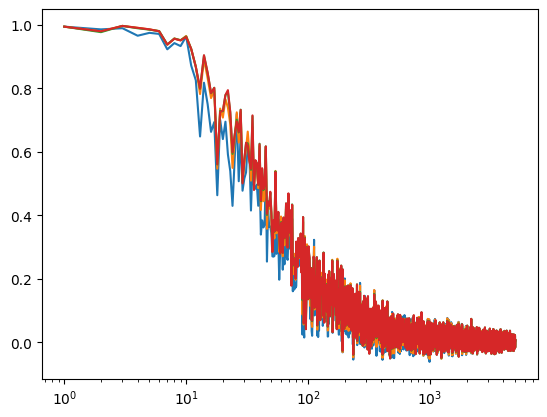

In [6]:
for p in plms:
    cross_corr_coeff(np.split(p, 1)[0], alpha_sim, plot = True)

plt.xscale("log")

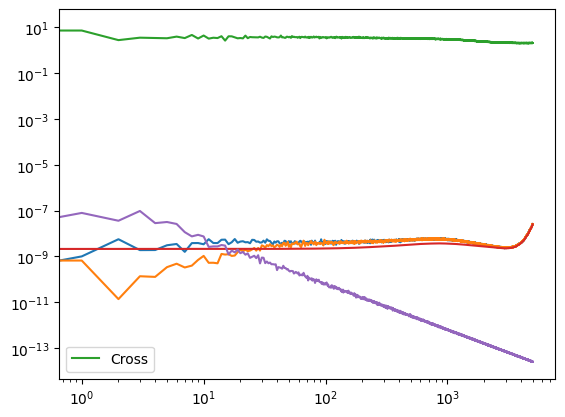

In [7]:
dir = "noise_biases/"
ngg = np.loadtxt(f"{dir}ngg_a_QE.txt")[:5001]

ngg_10 = np.loadtxt(f"{dir}ngg_a_itr_10.txt")[:5001]
n1_ap_10 = np.loadtxt(f"{dir}/n1_ap_itr_10.txt")
ff = (ngg_10**2)[:5001]

input_alpha = hp.read_alm(f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/a_new/simswalpha/sim_0000_alpha_lm.fits")
input_alpha = utils.alm_copy(input_alpha, lmax = 5000)
qdpart = np.load(f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/a_new_version_{v}_recs/p_p_sim0000{v}/plm_qd_partp{it:03}__sim0000_which_a.npy")
cross = hp.alm2cl(qdpart, input_alpha)

rands = np.array([np.load(f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/a_new_version_{v}_recs/p_p_sim0000{v}/plm_N0p{it:03}_v4_vrandnew2_sims_v3_sim{i:04}_which_a.npy") for i in range(5)])
mean = rands.mean(axis = 0)
rand, data, cross = mean.T
fac = ff
plt.loglog(rand*fac)
plt.loglog(data*fac)
plt.plot(cross*ngg_10, label = "Cross")
plt.plot(ngg_10)
plt.plot(hp.alm2cl(input_alpha))
plt.legend()


# Joint

In [8]:
phi_sim = hp.read_alm("/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/afpo/simswalpha/sim_0000_plm.fits")
alpha_sim = hp.read_alm("/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/afpo/simswalpha/sim_0000_alpha_lm.fits")

alpha_sim_lensed = lensed_alpha(alpha_sim, phi_sim)

alpha_sim = utils.alm_copy(alpha_sim, lmax = 5000)
alpha_sim_lensed = utils.alm_copy(alpha_sim_lensed, lmax = 5000)


In [9]:
v = "apo_no_mf_Lmin_2"
v = "afpo_28_02"
#v = "apo_no_mf_Lmin_2_v8"
dir = f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/afpo_version_{v}_recs/p_p_sim0000{v}/"
plms = rec().load_plms(dir, itrs = [0, 1, 5])

INFO:: 03-03 19:17:32:: __main__.load_plms - *** Could only build up to itr number 4


/tmp/ipykernel_3051130/4239218090.py:12: RuntimeWarning: invalid value encountered in divide
  xcorr = x/np.sqrt(aa*bb)


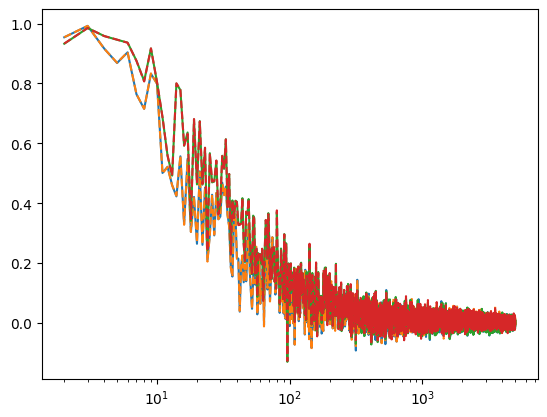

In [10]:
for p in plms:
    cross_corr_coeff(np.split(p, 4)[0], alpha_sim, plot = True)
    cross_corr_coeff(np.split(p, 4)[0], alpha_sim_lensed, plot = True, linestyle = "--")

plt.xscale("log")

/tmp/ipykernel_3051130/4239218090.py:12: RuntimeWarning: invalid value encountered in divide
  xcorr = x/np.sqrt(aa*bb)


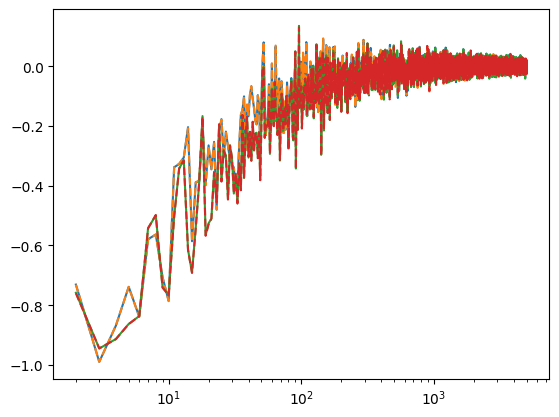

In [11]:
for p in plms:
    cross_corr_coeff(np.split(p, 4)[-1], alpha_sim, plot = True)
    cross_corr_coeff(np.split(p, 4)[-1], alpha_sim_lensed, plot = True, linestyle = "--")

plt.xscale("log")

In [12]:
from os.path import join as opj
import os
from plancklens import utils


def camb_clfile_gradient(fname, lmax=None):
    """CAMB spectra (lenspotentialCls, lensedCls or tensCls types) returned as a dict of numpy arrays.
    Args:
        fname (str): path to CAMB output file
        lmax (int, optional): outputs cls truncated at this multipole.
    """
    cols = np.loadtxt(fname).transpose()
    ell = np.int_(cols[0])
    if lmax is None: lmax = ell[-1]
    assert ell[-1] >= lmax, (ell[-1], lmax)
    cls = {k : np.zeros(lmax + 1, dtype=float) for k in ['tt', 'ee', 'bb', 'te']}
    w = ell * (ell + 1) / (2. * np.pi)  # weights in output file
    idc = np.where(ell <= lmax) if lmax is not None else np.arange(len(ell), dtype=int)
    for i, k in enumerate(['tt', 'ee', 'bb', 'te']):
        cls[k][ell[idc]] = cols[i + 1][idc] / w[idc]
    return cls

cls_path = opj(os.environ['HOME'], 'jointmap', 'data')
#cls_path = opj("/Users/omard/Downloads/", 'giulio')
cls_unl = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lenspotentialCls.dat'))
cls_len = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lensedCls.dat'))
cls_grad = camb_clfile_gradient(opj(cls_path, 'lensedCMB_dmn1_lensedgradCls.dat'))
cls_rot = np.loadtxt(opj(cls_path, 'new_lensedCMB_dmn1_field_rotation_power.dat')).T[1]

from plancklens.utils import cli

ls = np.arange(cls_rot.size)
factor = cli(ls*(ls+1)/2)
cls_rot = cls_rot*factor**2.


In [13]:
ell = np.arange(0, len(cls_unl["tt"])+1)
ACB = 7
cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**(1)
cls_alpha[0] = 0
cls_alpha = cls_alpha[:5200]

/tmp/ipykernel_3051130/3208282348.py:3: RuntimeWarning: divide by zero encountered in divide
  cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**(1)


In [131]:
caso_s4 = "" #cmb-s4
caso_so = "_so"
caso_spt = "_spt"

caso = caso_s4

SO_name = "so"
SPT_name = "spt"
S4_name = "s4"
names = {caso_s4:S4_name, caso_so:SO_name, caso_spt:SPT_name}

name = names[caso]
dir = f"{name}data/"
print(dir)

s4data/


In [132]:
from plancklens import nhl, n0s, qresp

nlev_tdict = {caso_s4: 1., caso_so: 6., caso_spt: 1.6}
beam_fwhm_dict = {caso_s4: 1., caso_so: 1.4, caso_spt: 1.4}

nlev_t = nlev_tdict[caso]
nlev_p = nlev_t*np.sqrt(2)
beam_fwhm = beam_fwhm_dict[caso]
cls_unl_fid = cls_unl
lmin_cmb = 30
lmin_blm, lmin_elm, lmin_tlm = lmin_cmb, lmin_cmb, lmin_cmb
lmax_cmb = 4000
itermax = 10
ret_curl = True

qe_key_A = f"x_p"
qe_key_B = f"a_p"
source_A = "x"
source_B = "a"

lmax_qlm = 5120

In [133]:
it = 0
fal, dat_delcls, cls_w, cls_f = np.load(f"{dir}fal_{it}.npy", allow_pickle=True).take(0), np.load(f"{dir}dat_delcls_{it}.npy", allow_pickle=True).take(0), np.load(f"{dir}cls_w_{it}.npy", allow_pickle=True).take(0), np.load(f"{dir}cls_f_{it}.npy", allow_pickle=True).take(0)
cls_ivfs_arr = utils.cls_dot([fal, dat_delcls, fal])
cls_ivfs = dict()


for i, a in enumerate(['t', 'e', 'b']):
    for j, b in enumerate(['t', 'e', 'b'][i:]):
        if np.any(cls_ivfs_arr[i, j + i]):
            cls_ivfs[a + b] = cls_ivfs_arr[i, j + i]

n_gg_A_B = nhl.get_nhl(qe_key_A, qe_key_B, cls_w, cls_ivfs, lmax_cmb, lmax_cmb, lmax_out=lmax_qlm)[1] #cross-noise
n_gg_A_A = nhl.get_nhl(qe_key_A, qe_key_A, cls_w, cls_ivfs, lmax_cmb, lmax_cmb, lmax_out=lmax_qlm)[1] #auto-noise
n_gg_B_B = nhl.get_nhl(qe_key_B, qe_key_B, cls_w, cls_ivfs, lmax_cmb, lmax_cmb, lmax_out=lmax_qlm)[1] #auto-noise
r_gg_true_A = qresp.get_response(qe_key_A, lmax_cmb, source_A, cls_w, cls_f, fal, lmax_qlm=lmax_qlm)[1] #XX
r_gg_true_A_B = qresp.get_response(qe_key_A, lmax_cmb, source_B, cls_w, cls_f, fal, lmax_qlm=lmax_qlm)[-1] #X A
r_gg_true_B_A = qresp.get_response(qe_key_B, lmax_cmb, source_A, cls_w, cls_f, fal, lmax_qlm=lmax_qlm)[-1] # A X
r_gg_true_B = qresp.get_response(qe_key_B, lmax_cmb, source_B, cls_w, cls_f, fal, lmax_qlm=lmax_qlm)[0] # A A 
N0_unbiased_A_B = n_gg_A_B * utils.cli(r_gg_true_A * r_gg_true_B)  # N0 of QE estimator after rescaling by Rfid / Rtrue to make it unbiased
N0_unbiased_A_A = n_gg_A_A * utils.cli(r_gg_true_A * r_gg_true_A)  # N0 of QE estimator after rescaling by Rfid / Rtrue to make it unbiased
N0_unbiased_B_B = n_gg_B_B * utils.cli(r_gg_true_B * r_gg_true_B)  # N0 of QE estimator after rescaling by Rfid / Rtrue to make it unbiased

In [134]:
it = 10
fal, dat_delcls, cls_w, cls_f = np.load(f"{dir}fal_{it}.npy", allow_pickle=True).take(0), np.load(f"{dir}dat_delcls_{it}.npy", allow_pickle=True).take(0), np.load(f"{dir}cls_w_{it}.npy", allow_pickle=True).take(0), np.load(f"{dir}cls_f_{it}.npy", allow_pickle=True).take(0)
cls_ivfs_arr = utils.cls_dot([fal, dat_delcls, fal])
cls_ivfs = dict()


for i, a in enumerate(['t', 'e', 'b']):
    for j, b in enumerate(['t', 'e', 'b'][i:]):
        if np.any(cls_ivfs_arr[i, j + i]):
            cls_ivfs[a + b] = cls_ivfs_arr[i, j + i]

n_gg_A_B = nhl.get_nhl(qe_key_A, qe_key_B, cls_w, cls_ivfs, lmax_cmb, lmax_cmb, lmax_out=lmax_qlm)[1] #cross-noise
n_gg_A_A = nhl.get_nhl(qe_key_A, qe_key_A, cls_w, cls_ivfs, lmax_cmb, lmax_cmb, lmax_out=lmax_qlm)[1] #auto-noise
n_gg_B_B = nhl.get_nhl(qe_key_B, qe_key_B, cls_w, cls_ivfs, lmax_cmb, lmax_cmb, lmax_out=lmax_qlm)[1] #auto-noise
r_gg_true_A = qresp.get_response(qe_key_A, lmax_cmb, source_A, cls_w, cls_f, fal, lmax_qlm=lmax_qlm)[1] #XX
r_gg_true_A_B = qresp.get_response(qe_key_A, lmax_cmb, source_B, cls_w, cls_f, fal, lmax_qlm=lmax_qlm)[-1] #X A
r_gg_true_B_A = qresp.get_response(qe_key_B, lmax_cmb, source_A, cls_w, cls_f, fal, lmax_qlm=lmax_qlm)[-1] # A X
r_gg_true_B = qresp.get_response(qe_key_B, lmax_cmb, source_B, cls_w, cls_f, fal, lmax_qlm=lmax_qlm)[0] # A A 
N0_unbiased_A_B = n_gg_A_B * utils.cli(r_gg_true_A * r_gg_true_B)  # N0 of QE estimator after rescaling by Rfid / Rtrue to make it unbiased
N0_unbiased_A_A = n_gg_A_A * utils.cli(r_gg_true_A * r_gg_true_A)  # N0 of QE estimator after rescaling by Rfid / Rtrue to make it unbiased
N0_unbiased_B_B = n_gg_B_B * utils.cli(r_gg_true_B * r_gg_true_B)  # N0 of QE estimator after rescaling by Rfid / Rtrue to make it unbiased

/tmp/ipykernel_3051130/500663841.py:4: RuntimeWarning: invalid value encountered in divide
  plt.loglog(np.sqrt(omega/(omega+N0_unbiased_A_A)))


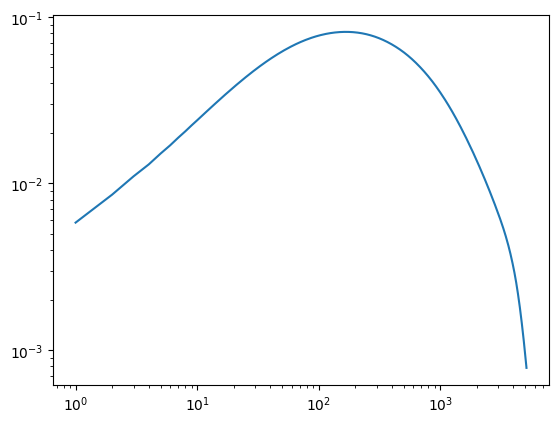

In [135]:
omega = cls_rot[:lmax_qlm+1]
alpha = cls_alpha[:lmax_qlm+1]

plt.loglog(np.sqrt(omega/(omega+N0_unbiased_A_A)))

In [136]:
def get_noises(it, cls_w_ = None, cls_f_ = None):
    fal, dat_delcls, cls_w, cls_f = np.load(f"{dir}fal_{it}.npy", allow_pickle=True).take(0), np.load(f"{dir}dat_delcls_{it}.npy", allow_pickle=True).take(0), np.load(f"{dir}cls_w_{it}.npy", allow_pickle=True).take(0), np.load(f"{dir}cls_f_{it}.npy", allow_pickle=True).take(0)
    cls_ivfs_arr = utils.cls_dot([fal, dat_delcls, fal])
    cls_ivfs = dict()

    if cls_w_ is not None:
        cls_w = cls_w_
    if cls_f_ is not None:
        cls_f = cls_f_

    for i, a in enumerate(['t', 'e', 'b']):
        for j, b in enumerate(['t', 'e', 'b'][i:]):
            if np.any(cls_ivfs_arr[i, j + i]):
                cls_ivfs[a + b] = cls_ivfs_arr[i, j + i]

    #n_gg_A_B = nhl.get_nhl(qe_key_A, qe_key_B, cls_w, cls_ivfs, lmax_cmb, lmax_cmb, lmax_out=lmax_qlm)[1] #cross-noise
    n_gg_A_A = nhl.get_nhl(qe_key_A, qe_key_A, cls_w, cls_ivfs, lmax_cmb, lmax_cmb, lmax_out=lmax_qlm)[1] #auto-noise
    n_gg_B_B = nhl.get_nhl(qe_key_B, qe_key_B, cls_w, cls_ivfs, lmax_cmb, lmax_cmb, lmax_out=lmax_qlm)[0] #auto-noise
    r_gg_true_A = qresp.get_response(qe_key_A, lmax_cmb, source_A, cls_w, cls_f, fal, lmax_qlm=lmax_qlm)[1] #XX
    r_gg_true_A_B = qresp.get_response(qe_key_A, lmax_cmb, source_B, cls_w, cls_f, fal, lmax_qlm=lmax_qlm)[-1] #X A
    r_gg_true_B_A = qresp.get_response(qe_key_B, lmax_cmb, source_A, cls_w, cls_f, fal, lmax_qlm=lmax_qlm)[-2] # A X
    r_gg_true_B = qresp.get_response(qe_key_B, lmax_cmb, source_B, cls_w, cls_f, fal, lmax_qlm=lmax_qlm)[0] # A A 
    #N0_unbiased_A_B = n_gg_A_B * utils.cli(r_gg_true_A * r_gg_true_B)  # N0 of QE estimator after rescaling by Rfid / Rtrue to make it unbiased
    N0_unbiased_A_A = n_gg_A_A * utils.cli(r_gg_true_A * r_gg_true_A)  # N0 of QE estimator after rescaling by Rfid / Rtrue to make it unbiased
    N0_unbiased_B_B = n_gg_B_B * utils.cli(r_gg_true_B * r_gg_true_B)  # N0 of QE estimator after rescaling by Rfid / Rtrue to make it unbiased

    return N0_unbiased_A_A, r_gg_true_A, r_gg_true_B, r_gg_true_A_B, r_gg_true_B_A, N0_unbiased_B_B

In [137]:
def get_get_rho(v = "apo_mf", cmb = "apo_new", itmax = 15, imin = 0, imax = 3, Nfs = 3, index = -1):
    d = "/home/users/d/darwish/scratch/joint_map_outputs/"
    autos = np.load(d+f"total_qe_it_p_p_{v}_{cmb}_{imin}_{imax}_{itmax}.npy")
    cross = np.load(d+f"total_qe_it_cross_p_p_{v}_{cmb}_{imin}_{imax}_{itmax}.npy")
    cross_down = np.load(d+f"total_qe_it_cross_down_p_p_{v}_{cmb}_{imin}_{imax}_{itmax}.npy")
    input_down = np.load(d+f"input_down_{v}_{cmb}_{imin}_{imax}_{itmax}.npy")
    input_field = np.load(d+f"input_{v}_{cmb}_{imin}_{imax}_{itmax}.npy")

    autos = autos.mean(axis = 0)
    cross = cross.mean(axis = 0)
    cross_down = cross_down.mean(axis = 0)
    input_down = input_down.mean(axis = 0)
    input_field = input_field.mean(axis = 0)

    autos = np.split(autos, Nfs, axis = -1)
    cross = np.split(cross, Nfs, axis = -1)
    cross_down = np.split(cross_down, Nfs, axis = -1)
    
    input = input_down[index]
    input_field = input_field[index]
    auto_omega = autos[index]
    cross_down_omega = cross_down[index]
    cross_omega = cross[index]

    get_rho_sim = lambda iteration: cross_down_omega[iteration]/np.sqrt(auto_omega[iteration]*input)
    get_rho_sim_auto = lambda iteration: cross_omega[iteration]/np.sqrt(auto_omega[iteration]*input_field)
    get_W = lambda iteration: cross_omega[iteration]/input_field

    return get_rho_sim, get_W, get_rho_sim_auto



/tmp/ipykernel_3051130/179752294.py:25: RuntimeWarning: invalid value encountered in divide
  get_rho_sim = lambda iteration: cross_down_omega[iteration]/np.sqrt(auto_omega[iteration]*input)


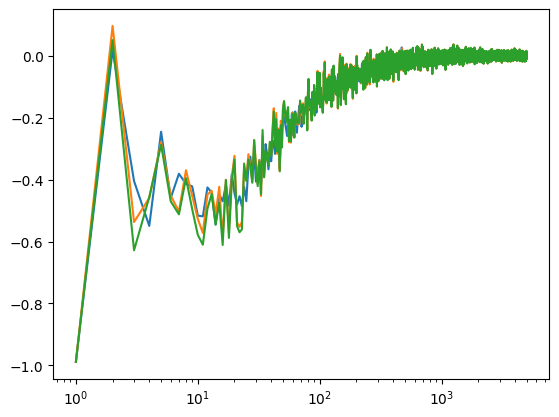

In [138]:
get_rho_sim, _, _ = get_get_rho(v = "afpo_20_02", cmb = "afpo", itmax = 20, imax = 7, Nfs = 4)
plt.plot(get_rho_sim(-1))
#plt.plot(get_rho_sim(1))


get_rho_sim, _, _ = get_get_rho(itmax = 15)
plt.plot(get_rho_sim(-1))
#plt.plot(get_rho_sim(1), ls = "--")
plt.xscale("log")


get_rho_sim, _, _ = get_get_rho(v = "apo_no_mf",itmax = 20)
plt.plot(get_rho_sim(-1))
#plt.plot(get_rho_sim(1), ls = "--")
plt.xscale("log")

In [139]:
dirn1 = "/home/users/d/darwish/jointmap/jobs/"
n1opQE = np.loadtxt(dirn1+"n1_op_QE.txt")
n1oaQE = np.loadtxt(dirn1+"n1_oa_QE.txt")
n1ooQE = np.loadtxt(dirn1+"n1_oo_QE.txt")

n1opMAP = np.loadtxt(dirn1+"n1_op_itr_10.txt")
n1oaMAP = np.loadtxt(dirn1+"n1_oa_itr_10.txt")
n1ooMAP = np.loadtxt(dirn1+"n1_oo_itr_10.txt")

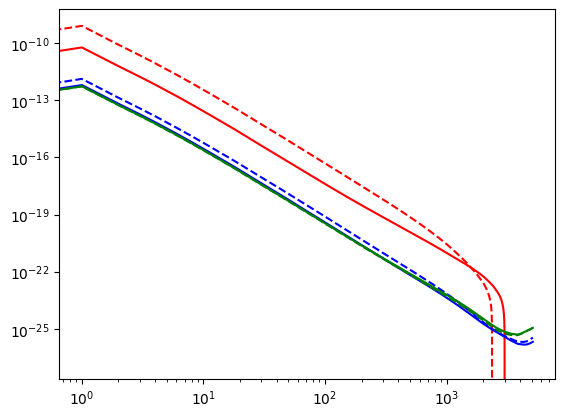

In [140]:
plt.loglog(n1opMAP, color = "red")
plt.loglog(n1opQE, color = "red", ls = "--")
plt.loglog(n1oaMAP, color = "blue")
plt.loglog(n1oaQE, color = "blue", ls = "--")
plt.plot(n1ooMAP, color = "green")
plt.plot(n1ooQE, color = "green", ls = "--")

/tmp/ipykernel_3051130/2552000610.py:9: RuntimeWarning: invalid value encountered in divide
  rho_QE = contamination_cross/np.sqrt((omega+N0_unbiased_A_A+n1opQE[:lmax_qlm+1]+n1oaQE[:lmax_qlm+1]+contamination_auto)*alpha)
/tmp/ipykernel_3051130/2552000610.py:37: RuntimeWarning: invalid value encountered in divide
  plt.plot(contamination_cross/np.sqrt((omega+N0_unbiased_A_A+contamination_auto+n1opMAP[:lmax_qlm+1]+n1oaMAP[:lmax_qlm+1])*alpha))


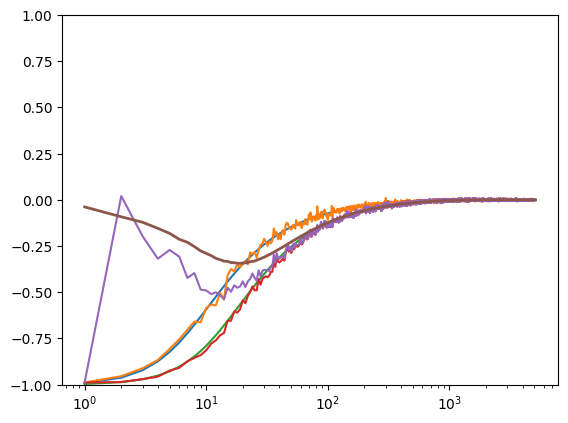

In [141]:
iconfig, itr = 0, 0
el, cross = np.loadtxt(f"crosso_iconfig_{iconfig}_itr_{itr}.txt").T

N0_unbiased_A_A, r_gg_true_A, r_gg_true_B, r_gg_true_A_B, r_gg_true_B_A, N0_unbiased_B_B = get_noises(itr)
contamination_cross = cli(r_gg_true_A)*r_gg_true_A_B*alpha
contamination_auto = (cli(r_gg_true_A)*r_gg_true_A_B)**2*alpha
WQE = alpha/(alpha+N0_unbiased_B_B)
r_gg_true_B_QE = r_gg_true_B
rho_QE = contamination_cross/np.sqrt((omega+N0_unbiased_A_A+n1opQE[:lmax_qlm+1]+n1oaQE[:lmax_qlm+1]+contamination_auto)*alpha)
plt.plot(rho_QE)
plt.plot(el, cross)

stuff = {}
stuff["N0_unbiased_A_A"] = N0_unbiased_A_A
stuff["r_gg_true_A"] = r_gg_true_A
stuff["r_gg_true_B"] = r_gg_true_B
stuff["r_gg_true_A_B"] = r_gg_true_A_B
stuff["r_gg_true_B_A"] = r_gg_true_B_A
stuff["N0_unbiased_B_B"] = N0_unbiased_B_B
stuff["n1oaQE"] = n1oaQE
stuff["n1opQE"] = n1opQE
stuff["n1ooQE"] = n1ooQE
np.save("stuff_QE_A_omega_B_alpha.npy", stuff)


iconfig, itr = 1, 15
el, cross = np.loadtxt(f"crosso_iconfig_{iconfig}_itr_{itr}.txt").T
itr = 10
N0_unbiased_A_A, r_gg_true_A, r_gg_true_B, r_gg_true_A_B, r_gg_true_B_A, N0_unbiased_B_B = get_noises(itr)

W = alpha/(alpha+N0_unbiased_B_B)
W = alpha/(alpha+N0_unbiased_B_B)

contamination_cross = cli(r_gg_true_A)*r_gg_true_A_B*alpha

contamination_auto = (cli(r_gg_true_A)*r_gg_true_A_B)**2*alpha
plt.plot(contamination_cross/np.sqrt((omega+N0_unbiased_A_A+contamination_auto+n1opMAP[:lmax_qlm+1]+n1oaMAP[:lmax_qlm+1])*alpha))
plt.plot(el, cross)

iconfig, itr = 0, 15
el, cross = np.loadtxt(f"crosso_iconfig_{iconfig}_itr_{itr}.txt").T
el, crossa = np.loadtxt(f"crossa_iconfig_{iconfig}_itr_{itr}.txt").T
ls = np.arange(alpha.size)
crossa_interp = np.interp(ls, el, crossa)
W = alpha/(alpha+N0_unbiased_B_B)
rho_th = W
alpha_res = (1-crossa_interp**2)*alpha
alpha_res_cross = (1-W)*alpha

#alpha_res_cross = alpha
#alpha_res = alpha

stuff = {}
stuff["N0_unbiased_A_A"] = N0_unbiased_A_A
stuff["r_gg_true_A"] = r_gg_true_A
stuff["r_gg_true_B"] = r_gg_true_B
stuff["r_gg_true_A_B"] = r_gg_true_A_B
stuff["r_gg_true_B_A"] = r_gg_true_B_A
stuff["N0_unbiased_B_B"] = N0_unbiased_B_B
stuff["n1oaMAP"] = n1oaMAP
stuff["n1opMAP"] = n1opMAP
stuff["n1ooMAP"] = n1ooMAP
np.save("stuff_MAP_A_omega_B_alpha.npy", stuff)

plt.plot(el, cross)
contamination_cross = cli(r_gg_true_A)*r_gg_true_A_B*alpha_res_cross
contamination_auto = (cli(r_gg_true_A)*r_gg_true_A_B)**2*alpha_res
rho_MAP = contamination_cross/np.sqrt((omega+N0_unbiased_A_A+contamination_auto+n1opMAP[:lmax_qlm+1]+n1oaMAP[:lmax_qlm+1])*alpha)
plt.plot(rho_MAP, lw = 2)

np.savetxt("rhos.txt", np.c_[rho_QE, rho_MAP])

plt.ylim(-1, 1)
plt.xscale("log")

In [ ]:
r_gg_true_A, r_gg_true_B, r_gg_true_A_B, r_gg_true_B_A

/tmp/ipykernel_3051130/2168559408.py:1: RuntimeWarning: invalid value encountered in divide
  r_gg_true_A/r_gg_true_A_B, r_gg_true_A/r_gg_true_B_A
/tmp/ipykernel_3051130/2168559408.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(-r_gg_true_A_B/np.sqrt(r_gg_true_A*r_gg_true_B))


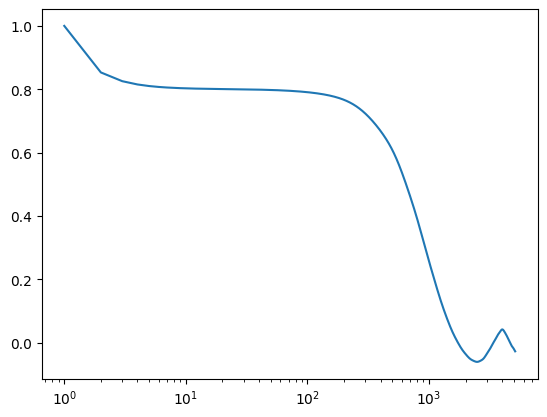

In [150]:
r_gg_true_A/r_gg_true_A_B, r_gg_true_A/r_gg_true_B_A

plt.plot(-r_gg_true_A_B/np.sqrt(r_gg_true_A*r_gg_true_B))
plt.xscale("log")

In [155]:
from delensalot.core.iterator import statics
alpha_sim = hp.read_alm("/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/apo_new/simswalpha/sim_0000_alpha_lm.fits")
alpha_sim = utils.alm_copy(alpha_sim, lmax = 5000)

v = "apo_new_official_no_fortran_od"
Nf = 3
dir = f"/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/apo_new_version_{v}_recs/p_p_sim0000{v}/"
it = 15
plms = statics.rec().load_plms(dir, itrs = [0, it-2, it])

INFO:: 03-04 02:03:24:: delensalot.core.iterator.statics.load_plms - *** Could only build up to itr number 13


/tmp/ipykernel_3051130/1795936486.py:18: RuntimeWarning: invalid value encountered in divide
  rho_MAP = contamination_cross/np.sqrt((omega+N0_unbiased_A_A+contamination_auto+n1opMAP[:lmax_qlm+1]+n1oaMAP[:lmax_qlm+1]+n1ooMAP[:lmax_qlm+1])*alpha)
/tmp/ipykernel_3051130/179752294.py:25: RuntimeWarning: invalid value encountered in divide
  get_rho_sim = lambda iteration: cross_down_omega[iteration]/np.sqrt(auto_omega[iteration]*input)


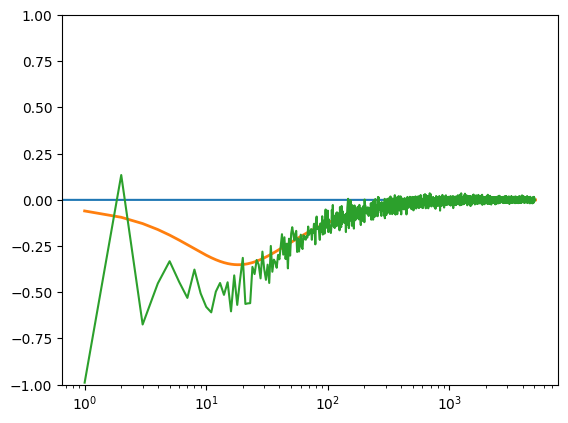

/tmp/ipykernel_3051130/179752294.py:26: RuntimeWarning: invalid value encountered in divide
  get_rho_sim_auto = lambda iteration: cross_omega[iteration]/np.sqrt(auto_omega[iteration]*input_field)
/tmp/ipykernel_3051130/1795936486.py:37: RuntimeWarning: invalid value encountered in divide
  plt.plot(contaminant/np.sqrt((contaminant+N0_contaminant)*contaminant))
/tmp/ipykernel_3051130/4239218090.py:12: RuntimeWarning: invalid value encountered in divide
  xcorr = x/np.sqrt(aa*bb)


array([        nan,         nan,  0.97961882, ...,  0.00341437,
       -0.00641136,  0.00901399])

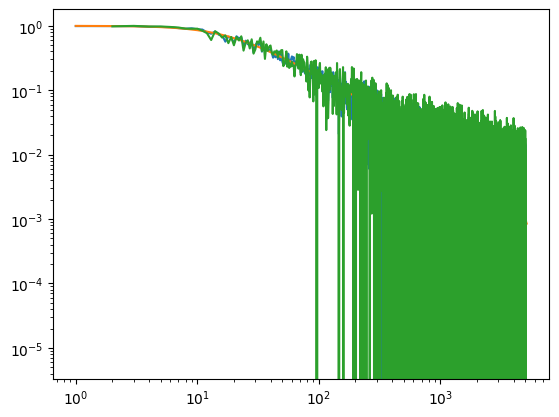

In [157]:
n1_ap_10 = np.loadtxt("noise_biases/n1_ap_itr_10.txt")
n1_ap_QE = np.loadtxt("noise_biases/n1_ap_QE.txt")
plt.plot(el, cross)

N0_contaminant = N0_unbiased_B_B
contaminant = alpha
W = contaminant/(contaminant+N0_contaminant+n1_ap_10)
#W = WQE
rho_th_a = np.sqrt(W)
rho_th = crossa_interp
alpha_res_cross = (1-W)*contaminant
alpha_res = (1-rho_th_a**2)*contaminant

resp_A_B = r_gg_true_A_B
resp_A_A = r_gg_true_A
contamination_cross = utils.cli(resp_A_A)*resp_A_B*alpha_res_cross
contamination_auto = (utils.cli(resp_A_A)*resp_A_B)**2*alpha_res
rho_MAP = contamination_cross/np.sqrt((omega+N0_unbiased_A_A+contamination_auto+n1opMAP[:lmax_qlm+1]+n1oaMAP[:lmax_qlm+1]+n1ooMAP[:lmax_qlm+1])*alpha)
plt.plot(rho_MAP, lw = 2)

#get_rho_sim, get_W_omega = get_get_rho(v = "afpo_20_02", cmb = "afpo", itmax = 20, imax = 7, Nfs = 4)
#get_rho_sim_omega, get_W_alpha = get_get_rho(v = "afpo_20_02", cmb = "afpo", itmax = 20, imax = 7, Nfs = 4, index = 0)
#plt.plot(get_rho_sim(-1))

v = "apo_new_official_new_complex"
itmax = 13
get_rho_sim, get_W_omega, get_rho_sim_auto = get_get_rho(v = v, cmb = "apo_new", itmax = itmax, imax = 3, Nfs = 3)
get_rho_sim_alpha, get_W_alpha, get_rho_sim_auto_alpha = get_get_rho(v = v, cmb = "apo_new", itmax = itmax, imax = 3, Nfs = 3, index = 0)
plt.plot(get_rho_sim(-1))
#plt.plot(get_rho_sim(15))

plt.ylim(-1, 1)
plt.xscale("log")
plt.show()

plt.loglog(get_rho_sim_auto_alpha(-1))
plt.plot(contaminant/np.sqrt((contaminant+N0_contaminant)*contaminant))

cross_corr_coeff(np.split(p, Nf)[0], alpha_sim, plot = True)



/tmp/ipykernel_3051130/1124412802.py:7: RuntimeWarning: invalid value encountered in divide
  WFF = cross/input


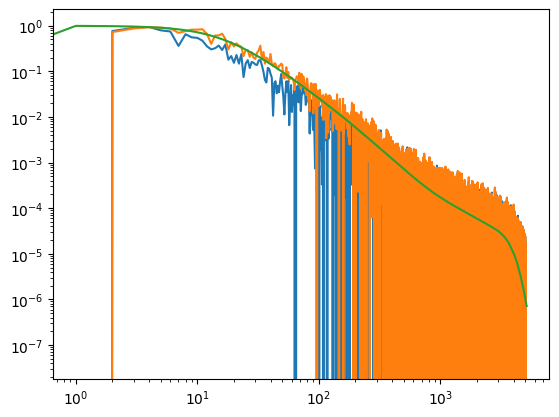

In [156]:

W = contaminant/(contaminant+N0_contaminant+n1_ap_10)
#plt.plot(get_W_alpha(-1))

input = hp.alm2cl(alpha_sim)
for p in plms:
    cross = hp.alm2cl(np.split(p, Nf)[0], alpha_sim)
    WFF = cross/input
    plt.plot(WFF)
    #norm_alpha = hp.almxfl(alpha_sim, utils.cli(WF))
    #cross_corr_coeff(np.split(p, Nf)[0], alpha_sim, plot = True)
    #WF = cross/input
    #plt.loglog(WF)
plt.loglog(W)

In [ ]:
plms = rec.load_plms("/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/afpo_version_afpo_20_02_recs/p_p_sim0000afpo_20_02", itrs = [0, 15])

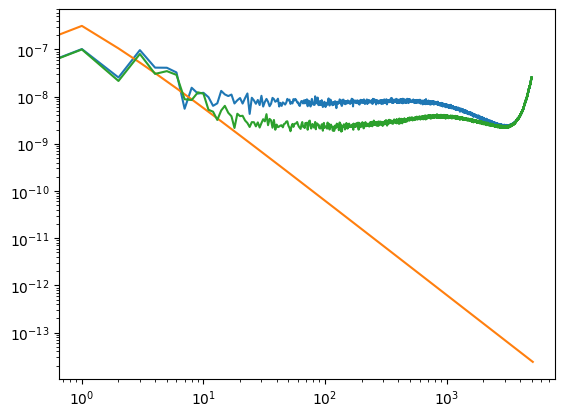

In [75]:
recA = np.split(plms[0], 4)[0]
recA = hp.almxfl(recA, utils.cli(WQE))
plt.loglog(hp.alm2cl(recA))
plt.plot(alpha)

recA = np.split(plms[-1], 4)[0]
recA = hp.almxfl(recA, utils.cli(W))
plt.loglog(hp.alm2cl(recA))

/tmp/ipykernel_2739757/288146205.py:26: RuntimeWarning: invalid value encountered in divide
  get_W = lambda iteration: cross_omega[iteration]/input_field


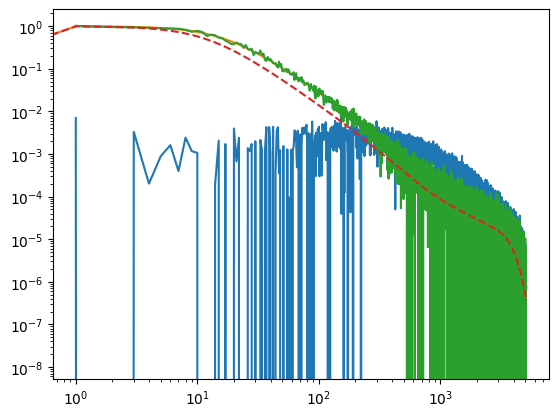

In [49]:
plt.loglog(get_W_omega(0))
W = contaminant/(contaminant+N0_contaminant)
plt.plot(W)
plt.loglog(get_W_alpha(-1))
W = contaminant/(contaminant+2*N0_contaminant)
plt.plot(W, ls = "--")

/tmp/ipykernel_2739757/1671397798.py:21: RuntimeWarning: invalid value encountered in divide
  get_rho_sim = lambda iteration: cross_down_omega[iteration]/np.sqrt(auto_omega[iteration]*input)
/tmp/ipykernel_2739757/4223254355.py:8: RuntimeWarning: invalid value encountered in divide
  plt.plot(contamination_cross/np.sqrt((alpha+N0_unbiased_B_B+contamination_auto)*omega))
/tmp/ipykernel_2739757/4223254355.py:9: RuntimeWarning: invalid value encountered in divide
  QE = contamination_cross/np.sqrt((alpha+N0_unbiased_B_B+contamination_auto)*omega)
/tmp/ipykernel_2739757/4223254355.py:15: RuntimeWarning: invalid value encountered in divide
  W = omega/(omega+N0_unbiased_A_A)
/tmp/ipykernel_2739757/4223254355.py:23: RuntimeWarning: invalid value encountered in divide
  plt.plot(contamination_cross/np.sqrt((alpha+N0_unbiased_B_B+contamination_auto)*omega))
/tmp/ipykernel_2739757/4223254355.py:24: RuntimeWarning: invalid value encountered in divide
  MAP = contamination_cross/np.sqrt((alpha+N

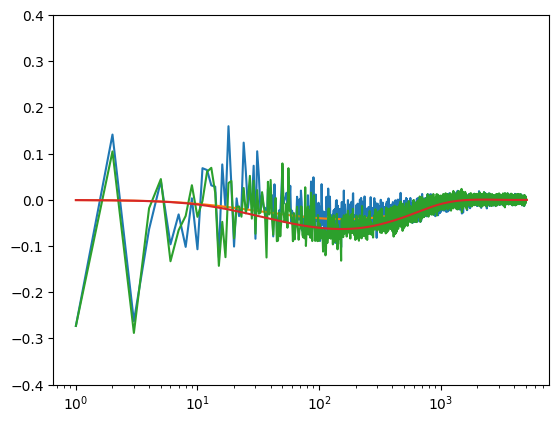

In [27]:
iconfig, itr = 0, 0

plt.plot(get_rho_sim_omega(0))

N0_unbiased_A_A, r_gg_true_A, r_gg_true_B, r_gg_true_A_B, r_gg_true_B_A, N0_unbiased_B_B = get_noises(itr)
contamination_cross = cli(r_gg_true_B)*r_gg_true_B_A*omega
contamination_auto = (cli(r_gg_true_B)*r_gg_true_B_A)**2*omega
plt.plot(contamination_cross/np.sqrt((alpha+N0_unbiased_B_B+contamination_auto)*omega))
QE = contamination_cross/np.sqrt((alpha+N0_unbiased_B_B+contamination_auto)*omega)

itr = 10
plt.plot(get_rho_sim_omega(-1))
N0_unbiased_A_A, r_gg_true_A, r_gg_true_B, r_gg_true_A_B, r_gg_true_B_A, N0_unbiased_B_B = get_noises(itr)

W = omega/(omega+N0_unbiased_A_A)
rho_th = np.sqrt(W)
residual = (1-rho_th**2)*omega #(1-W)**2*alpha#(1-rho_th**2)*alpha
residual_cross = (1-W)*omega


contamination_cross = cli(r_gg_true_B)*r_gg_true_B_A*omega
contamination_auto = (cli(r_gg_true_B)*r_gg_true_B_A)**2*omega
plt.plot(contamination_cross/np.sqrt((alpha+N0_unbiased_B_B+contamination_auto)*omega))
MAP = contamination_cross/np.sqrt((alpha+N0_unbiased_B_B+contamination_auto)*omega)

np.savetxt("rho_alpha_contamined_omega.txt", np.c_[QE, MAP], header = "QE MAP")

"""iconfig, itr = 1, 15
el, cross = np.loadtxt(f"crosso_iconfig_{iconfig}_itr_{itr}.txt").T
itr = 10
N0_unbiased_A_A, r_gg_true_A, r_gg_true_B, r_gg_true_A_B, r_gg_true_B_A, N0_unbiased_B_B = get_noises(itr)

W = alpha/2/(alpha/2+N0_unbiased_B_B)
W = alpha/(alpha+N0_unbiased_B_B)

contamination_cross = cli(r_gg_true_A)*r_gg_true_A_B*alpha

contamination_auto = (cli(r_gg_true_A)*r_gg_true_A_B)**2*alpha
plt.plot(contamination_cross/np.sqrt((omega+N0_unbiased_A_A+contamination_auto+n1opMAP[:lmax_qlm+1]+n1oaMAP[:lmax_qlm+1])*alpha))
plt.plot(el, cross)

iconfig, itr = 0, 15
el, cross = np.loadtxt(f"crosso_iconfig_{iconfig}_itr_{itr}.txt").T
el, crossa = np.loadtxt(f"crossa_iconfig_{iconfig}_itr_{itr}.txt").T
ls = np.arange(alpha.size)
crossa_interp = np.interp(ls, el, crossa)
W = alpha/(alpha+N0_unbiased_B_B)
rho_th = W
alpha_res = (1-crossa_interp**2)*alpha
alpha_res_cross = (1-W)*alpha


plt.plot(el, cross)
contamination_cross = cli(r_gg_true_A)*r_gg_true_A_B*alpha_res_cross
contamination_auto = (cli(r_gg_true_A)*r_gg_true_A_B)**2*alpha_res
plt.plot(contamination_cross/np.sqrt((omega+N0_unbiased_A_A+contamination_auto+n1opMAP[:lmax_qlm+1]+n1oaMAP[:lmax_qlm+1])*alpha), lw = 2)
"""
plt.ylim(-0.4, 0.4)
plt.xscale("log")

In [28]:
W = alpha/(alpha+N0_unbiased_B_B)
rho_th = W
rho_th = crossa_interp
alpha_res = (1-rho_th**2)*alpha
alpha_res_cross = (1-W)*alpha

In [29]:
(1-rho_th**2)/(1-W)**2

array([         nan, 535.68178394,  46.01020919, ...,   0.99999794,
         0.99999794,   0.99999794])

In [26]:
from os.path import join as opj
import os
from plancklens import utils


def camb_clfile_gradient(fname, lmax=None):
    """CAMB spectra (lenspotentialCls, lensedCls or tensCls types) returned as a dict of numpy arrays.
    Args:
        fname (str): path to CAMB output file
        lmax (int, optional): outputs cls truncated at this multipole.
    """
    cols = np.loadtxt(fname).transpose()
    ell = np.int_(cols[0])
    if lmax is None: lmax = ell[-1]
    assert ell[-1] >= lmax, (ell[-1], lmax)
    cls = {k : np.zeros(lmax + 1, dtype=float) for k in ['tt', 'ee', 'bb', 'te']}
    w = ell * (ell + 1) / (2. * np.pi)  # weights in output file
    idc = np.where(ell <= lmax) if lmax is not None else np.arange(len(ell), dtype=int)
    for i, k in enumerate(['tt', 'ee', 'bb', 'te']):
        cls[k][ell[idc]] = cols[i + 1][idc] / w[idc]
    return cls

cls_path = opj(os.environ['HOME'], 'jointmap', 'data')
#cls_path = opj("/Users/omard/Downloads/", 'giulio')
cls_unl = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lenspotentialCls.dat'))
cls_len = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lensedCls.dat'))
cls_grad = camb_clfile_gradient(opj(cls_path, 'lensedCMB_dmn1_lensedgradCls.dat'))
cls_rot = np.loadtxt(opj(cls_path, 'new_lensedCMB_dmn1_field_rotation_power.dat')).T[1]

from plancklens.utils import cli

ls = np.arange(cls_rot.size)
factor = cli(ls*(ls+1)/2)
cls_rot = cls_rot*factor**2.


In [27]:
from lenspyx.wigners import wigners
def wignerc(cl1: np.ndarray, cl2:np.ndarray, s1: int, t1: int, s2: int, t2: int,
            lmax_out: int = -1):

    lmax1 = len(cl1) - 1
    lmax2 = len(cl2) - 1
    lmax_out = lmax1 + lmax2 if lmax_out < 0 else lmax_out
    lmax_tot = lmax1 + lmax2 + lmax_out
    so = s1 + s2
    to = t1 + t2
    if np.any(cl1) and np.any(cl2):
        npts = (lmax_tot + 2 - lmax_tot % 2) // 2
        if not 'tht wg %s' % npts in wigners.GL_cache.keys():
            wigners.GL_cache['tht wg %s' % npts] = wigners.get_thgwg(npts)
        tht, wg = wigners.GL_cache['tht wg %s' % npts]
        if np.iscomplexobj(cl1):
            xi1 = wigners.wignerpos(np.real(cl1), tht, s1, t1) + 1j * wigners.wignerpos(np.imag(cl1), tht, s1, t1)
        else:
            xi1 = wigners.wignerpos(cl1, tht, s1, t1)
            print("Take exponential!!", t2)
            xi1 = np.exp(4*(-1 if t2 < 0 else 1)*xi1)
        if np.iscomplexobj(cl2):
            xi2 = wigners.wignerpos(np.real(cl2), tht, s2, t2) + 1j * wigners.wignerpos(np.imag(cl2), tht, s2, t2)
        else:
            xi2 = wigners.wignerpos(cl2, tht, s2, t2)
        xi1xi2w = xi1 * xi2 * wg
        if np.iscomplexobj(xi1xi2w):
            ret =wigners.wignercoeff(np.real(xi1xi2w), tht, so, to, lmax_out)
            ret = ret + 1j * wigners.wignercoeff(np.imag(xi1xi2w), tht, so, to, lmax_out)
            return ret
        else:
            return wigners.wignercoeff(xi1xi2w, tht, so, to, lmax_out)
    else:
        return np.zeros(lmax_out + 1, dtype=float)


In [28]:
lmax_w = 6000
ell = np.arange(0, len(cls_unl["tt"])+1)
ACB = 7
cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**(1)
cls_alpha[0] = 0
cls_alpha = cls_alpha[:5200]
somma = wignerc(cls_alpha, cls_unl["ee"], 0, 0, 2, 2, lmax_w) #EE+BB
diff = wignerc(cls_alpha, cls_unl["ee"], 0, 0, 2, -2, lmax_w) #EE-BB
cl_bb_rotated = (somma-diff)/2
cl_ee_rotated = (somma+diff)/2

Take exponential!! 2
Take exponential!! -2


/tmp/ipykernel_3051130/698126378.py:4: RuntimeWarning: divide by zero encountered in divide
  cls_alpha = 10**(-ACB)*2*np.pi/(ell*(ell+1))**(1)


In [105]:
alpha_sim = hp.read_alm("/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/a_new/simswalpha/sim_0000_alpha_lm.fits")
alpha_sim = utils.alm_copy(alpha_sim, lmax = 5000)

blm = hp.read_alm("/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/a_new/simswalpha/sim_0000_blm.fits")
elm = hp.read_alm("/home/users/d/darwish/scratch/JOINTRECONSTRUCTION/a_new/simswalpha/sim_0000_elm.fits")
clb = hp.alm2cl(blm)

In [106]:
lmax_in = hp.Alm.getlmax(blm.size)
lmax_in

5001

In [107]:
from lenspyx.remapping.utils_geom import Geom, pbdGeometry, pbounds
lmax_unl = 4000
lenjob_geometry = Geom.get_healpix_geometry(2048) 
#lenjob_geometry = get_thingauss_geometry(lmax_unl * 2, 2)
mmax_qlm = 5000
lmax_qlm = 5000
alpha_real = lenjob_geometry.synthesis(alpha_sim, spin = 0, lmax = lmax_qlm, mmax = mmax_qlm, nthreads = 128).squeeze()
sht_tr = 120

eblm = np.array([elm, blm])
QU = lenjob_geometry.synthesis(eblm.astype(np.complex128).copy(), 2, lmax_in, lmax_in, sht_tr)

In [117]:
c, s = np.cos(2*alpha_real), np.sin(2*alpha_real)
rotation = np.array([[c, -s], [s, c]]) #R
inv_rotation = np.array([[c, s], [-s, c]]) #R^\dagger
rotation_complex = np.exp(1j * 2* alpha_real)
inv_rotation_complex = np.exp(-1j * 2* alpha_real)

def _rotate_polarization(QU, rotation):
    result = np.einsum('abc, bc->ac', rotation, QU)
    return result

def _rotate_polarization_complex(QU, rotation):
        QpmU = QU[0] + 1j * QU[1]
        result = rotation*QpmU
        return np.array([result.real, result.imag])

In [109]:
result = np.einsum('ijn,kjn->ikn', rotation, inv_rotation)

In [110]:
result[..., 0]

array([[ 0.99997223,  0.00745243],
       [-0.00745243,  0.99997223]])

In [118]:
derot_QU = _rotate_polarization(QU, inv_rotation)
derot_QU_complex = _rotate_polarization_complex(QU, inv_rotation_complex)

In [119]:
derot_QU_complex.shape, derot_QU.shape

((2, 50331648), (2, 50331648))

In [120]:
elm_derot, blm_derot = lenjob_geometry.adjoint_synthesis(derot_QU, 2, lmax_in, lmax_in, sht_tr, apply_weights = True)
elm_derot_complex, blm_derot_complex = lenjob_geometry.adjoint_synthesis(derot_QU_complex, 2, lmax_in, lmax_in, sht_tr, apply_weights = True)

In [122]:
hp.alm2cl(blm_derot_complex), hp.alm2cl(blm_derot)

(array([0.00000000e+00, 0.00000000e+00, 2.92394232e-14, ...,
        8.74374127e-13, 8.71313206e-13, 8.87761084e-13]),
 array([0.00000000e+00, 0.00000000e+00, 2.92394232e-14, ...,
        8.74374127e-13, 8.71313206e-13, 8.87761084e-13]))

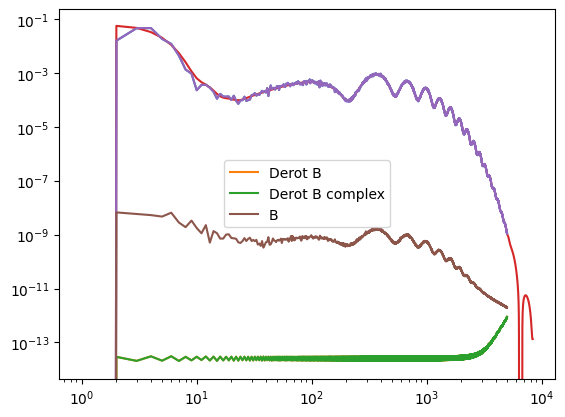

In [121]:
plt.loglog(hp.alm2cl(elm_derot))
plt.loglog(hp.alm2cl(blm_derot), label = "Derot B")


plt.loglog(hp.alm2cl(blm_derot_complex), label = "Derot B complex")


plt.plot(cls_unl["ee"])

plt.plot(hp.alm2cl(elm))
plt.plot(hp.alm2cl(blm), label = "B")
plt.legend()

/tmp/ipykernel_1351776/1459926223.py:1: RuntimeWarning: invalid value encountered in divide
  plt.loglog(hp.alm2cl(elm_derot)/hp.alm2cl(elm))
/tmp/ipykernel_1351776/1459926223.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot(cls_unl["ee"][:6001]/cl_ee_rotated[:6001])


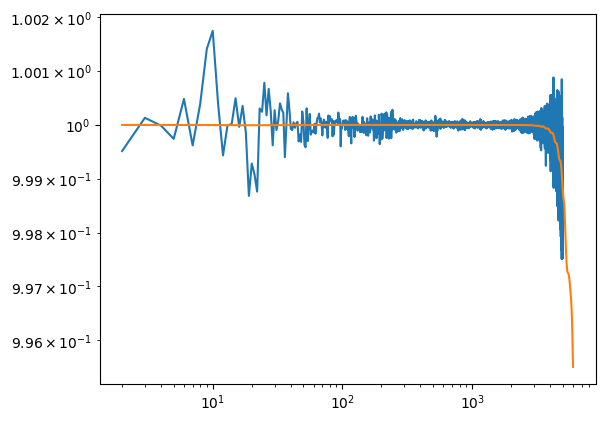

In [65]:
plt.loglog(hp.alm2cl(elm_derot)/hp.alm2cl(elm))
plt.plot(cls_unl["ee"][:6001]/cl_ee_rotated[:6001])

In [27]:
#np.savetxt("cl_rotated_e_b.txt", np.c_[cl_ee_rotated, cl_bb_rotated], header = "cl_ee_rot, cl_bb_rot")

In [15]:
cl_ee_rotated.size

6001

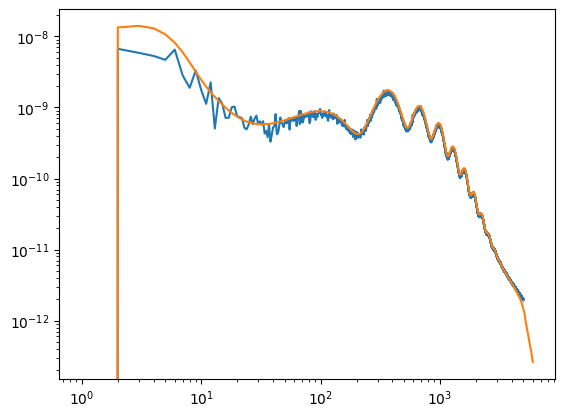

In [12]:
plt.loglog(clb)
plt.plot(cl_bb_rotated)

In [ ]:
lmax_w = 6000
somma = wignerc(cls_alpha, cls_len["ee"]+cls_len["bb"], 0, 0, 2, 2, lmax_w) #EE+BB
diff = wignerc(cls_alpha, cls_len["ee"]-cls_len["bb"], 0, 0, 2, -2, lmax_w) #EE-BB
cl_bb_rotated = (somma-diff)/2
cl_ee_rotated = (somma+diff)/2


it = 10
cls_w = np.load(f"{dir}cls_w_{it}.npy", allow_pickle=True).take(0)
cls_f = np.load(f"{dir}cls_f_{it}.npy", allow_pickle=True).take(0)

somma = wignerc(cls_alpha, cls_w["ee"]+cls_w["bb"], 0, 0, 2, 2, lmax_w) #EE+BB
diff = wignerc(cls_alpha, cls_w["ee"]-cls_w["bb"], 0, 0, 2, -2, lmax_w) #EE-BB
cl_bb_it_rotated = (somma-diff)/2
cl_ee_it_rotated = (somma+diff)/2


somma = wignerc(cls_alpha, cls_w["ee"]+cls_w["bb"], 0, 0, 2, 2, lmax_w) #EE+BB
diff = wignerc(cls_alpha, cls_w["ee"]-cls_w["bb"], 0, 0, 2, -2, lmax_w) #EE-BB
cl_bb_it_rotated = (somma-diff)/2
cl_ee_it_rotated = (somma+diff)/2

Take exponential!! 2
Take exponential!! -2
Take exponential!! 2
Take exponential!! -2


In [34]:
somma = wignerc(np.nan_to_num(alpha_res), cls_len["ee"]+cls_len["bb"], 0, 0, 2, 2, lmax_w) #EE+BB
diff = wignerc(np.nan_to_num(alpha_res), cls_len["ee"]-cls_len["bb"], 0, 0, 2, -2, lmax_w) #EE-BB

cl_bb_rotated_res = (somma-diff)/2
cl_ee_rotated_res = (somma+diff)/2

it = 10
cls_w = np.load(f"{dir}cls_w_{it}.npy", allow_pickle=True).take(0)
somma = wignerc(np.nan_to_num(alpha_res), cls_w["ee"]+cls_w["bb"], 0, 0, 2, 2, lmax_w) #EE+BB
diff = wignerc(np.nan_to_num(alpha_res), cls_w["ee"]-cls_w["bb"], 0, 0, 2, -2, lmax_w) #EE-BB
cl_bb_it_rotated_res = (somma-diff)/2
cl_ee_it_rotated_res = (somma+diff)/2

Take exponential!! 2
Take exponential!! -2
Take exponential!! 2
Take exponential!! -2


In [40]:
cls_w_copy = {x: y.copy() for x, y in cls_w.items()}
cls_w_copy["bb"] = cl_bb_rotated_res
cls_w_copy["ee"] = cl_ee_rotated_res

/tmp/ipykernel_600748/4000942288.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(cl_ee_it_rotated_res[:4000]/cls_w["ee"][:4000])
/tmp/ipykernel_600748/4000942288.py:1: RuntimeWarning: invalid value encountered in divide
  plt.loglog(cl_ee_it_rotated_res[:4000]/cls_w["ee"][:4000])
/tmp/ipykernel_600748/4000942288.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(cl_bb_it_rotated_res[:4000]/cls_w["bb"][:4000])
/tmp/ipykernel_600748/4000942288.py:2: RuntimeWarning: invalid value encountered in divide
  plt.loglog(cl_bb_it_rotated_res[:4000]/cls_w["bb"][:4000])


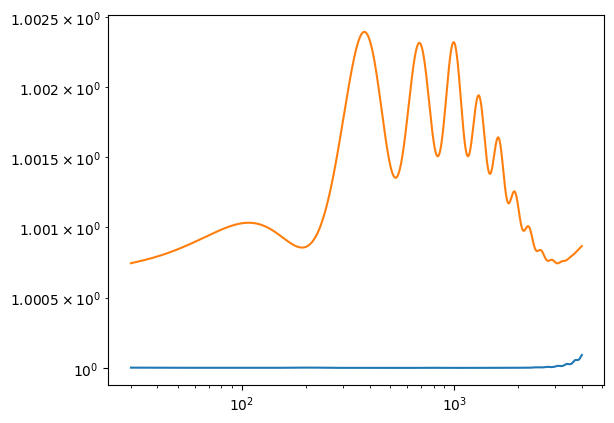

In [38]:
plt.loglog(cl_ee_it_rotated_res[:4000]/cls_w["ee"][:4000])
plt.loglog(cl_bb_it_rotated_res[:4000]/cls_w["bb"][:4000])

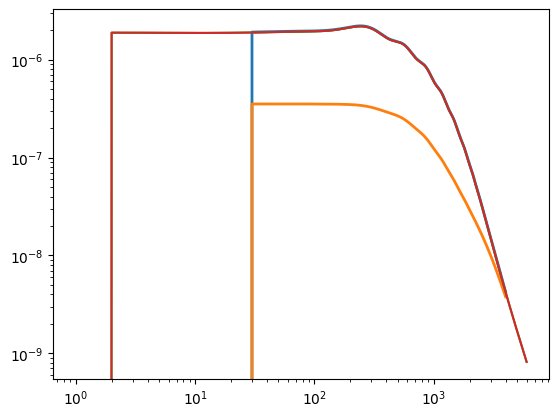

In [28]:
it = 0
cls_w, cls_f = np.load(f"{dir}cls_w_{it}.npy", allow_pickle=True).take(0), np.load(f"{dir}cls_f_{it}.npy", allow_pickle=True).take(0)
plt.plot(cls_w["bb"], lw = 2)


it = 10
cls_w, cls_f = np.load(f"{dir}cls_w_{it}.npy", allow_pickle=True).take(0), np.load(f"{dir}cls_f_{it}.npy", allow_pickle=True).take(0)
plt.plot(cls_w["bb"], lw = 2)

plt.loglog(cl_bb_rotated_res)
plt.plot(cl_bb_rotated)

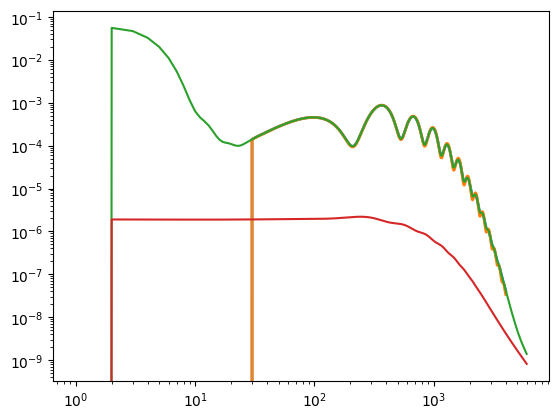

In [29]:
it = 0
cls_w, cls_f = np.load(f"{dir}cls_w_{it}.npy", allow_pickle=True).take(0), np.load(f"{dir}cls_f_{it}.npy", allow_pickle=True).take(0)
plt.plot(cls_w["ee"], lw = 2)


it = 10
cls_w, cls_f = np.load(f"{dir}cls_w_{it}.npy", allow_pickle=True).take(0), np.load(f"{dir}cls_f_{it}.npy", allow_pickle=True).take(0)
plt.plot(cls_w["ee"], lw = 2)

plt.loglog(cl_ee_rotated_res)
plt.plot(cl_bb_rotated)

In [ ]:
import numpy as np

# Create a 3D array of shape (lmax_qlm+1, 2, 2)
R_matrix = np.zeros((lmax_qlm+1, 2, 2))

# Fill the diagonal elements with ones
R_matrix[:, 0, 0] = r_gg_true_A
R_matrix[:, 1, 1] = r_gg_true_B

# Fill the off-diagonal elements
# Assuming r_gg_true_A_B and r_gg_true_B_A are arrays of shape (lmax_qlm+1,)
R_matrix[:, 0, 1] = r_gg_true_A_B
R_matrix[:, 1, 0] = r_gg_true_B_A

selection = r_gg_true_A>0
Rinverse = np.linalg.inv(R_matrix[selection, ...])
Roo = Rinverse[:, 0, 0]
Raa = Rinverse[:, 1, 1]

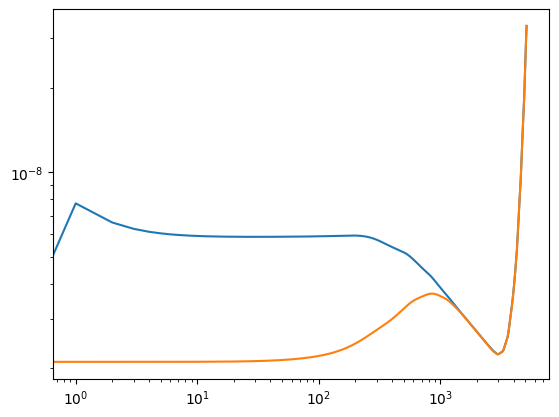

In [ ]:
#plt.loglog((Roo))
#plt.plot(cli(r_gg_true_A))


plt.loglog((Raa))
plt.plot(cli(r_gg_true_B))

/tmp/ipykernel_769294/1777657983.py:8: RuntimeWarning: invalid value encountered in divide
  rho_th_omega = np.sqrt(omega/(omega+N0_unbiased_A_A))
/tmp/ipykernel_769294/739338768.py:2: RuntimeWarning: invalid value encountered in divide
  get_rho_sim = lambda iteration: cross_down_omega[iteration]/np.sqrt(auto_omega[iteration]*input)


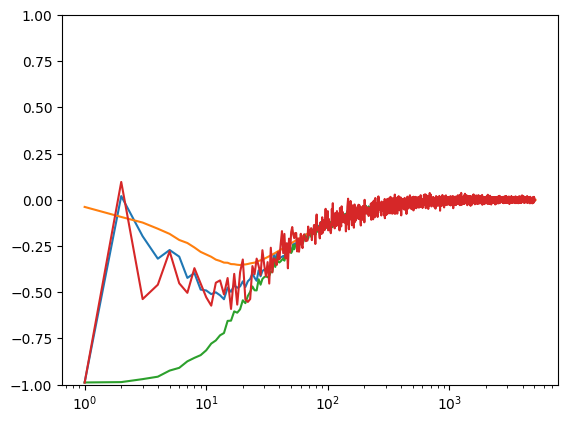

In [ ]:
iconfig, itr = 0, 15
el, cross = np.loadtxt(f"crosso_iconfig_{iconfig}_itr_{itr}.txt").T
el, crossa = np.loadtxt(f"crossa_iconfig_{iconfig}_itr_{itr}.txt").T
ls = np.arange(alpha.size)
crossa_interp = np.interp(ls, el, crossa)
W = alpha/(alpha+N0_unbiased_B_B)
rho_th = np.sqrt(W)
rho_th_omega = np.sqrt(omega/(omega+N0_unbiased_A_A))
alpha_res_cross = (1-W)*alpha
alpha_res = (1-crossa_interp**2)*alpha
#alpha_res = (1-rho_th**2)*alpha

plt.plot(el, cross)
contamination_cross = cli(r_gg_true_A)*r_gg_true_A_B*alpha_res_cross
contamination_auto = (cli(r_gg_true_A)*r_gg_true_A_B)**2*alpha_res
plt.plot(contamination_cross/np.sqrt((omega+N0_unbiased_A_A+contamination_auto)*alpha))

iconfig, itr = 1, 15
el, cross = np.loadtxt(f"crosso_iconfig_{iconfig}_itr_{itr}.txt").T
plt.plot(el, cross)


iteration = -1
plt.plot(get_rho_sim(iteration))

plt.ylim(-1, 1)
plt.xscale("log")

In [3]:
import numpy as np
x = np.ones(5)
x[:2] *= 0
x

array([0., 0., 1., 1., 1.])

In [55]:
_, r_gg_true_A, r_gg_true_B, r_gg_true_A_B, r_gg_true_B_A, _ = get_noises(10)
_, r_gg_true_A_alt, r_gg_true_B_alt, r_gg_true_A_B_alt, r_gg_true_B_A_alt, _ = get_noises(10, cls_w_ = cls_w_copy, cls_f_ = cls_w_copy)

In [56]:
X = cli(r_gg_true_A)*r_gg_true_A_B
Y = cli(r_gg_true_A_alt)*r_gg_true_A_B_alt

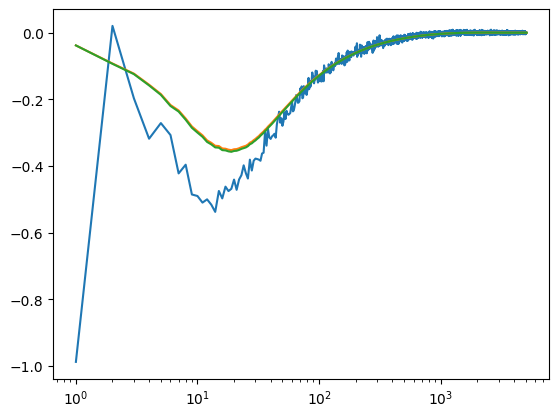

In [57]:
plt.plot(el, cross)
contamination_cross = X*alpha_res_cross
contamination_auto = X**2*alpha_res
plt.plot(contamination_cross/np.sqrt((omega+N0_unbiased_A_A+contamination_auto)*alpha))


contamination_cross = Y*alpha_res_cross
contamination_auto = X**2*alpha_res
plt.plot(contamination_cross/np.sqrt((omega+N0_unbiased_A_A+contamination_auto)*alpha))
plt.xscale("log")